# Start with Conditional Random Field

Starting the Kringing Conditional Random Field generation:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
# Prior distribution -  Unconditional Random Field

X = np.linspace(0, 20, 3)

# Prior distribution -  Unconditional Random Field
theta_x = 100

## Exponential autocorrelation
rho = np.exp(-2*np.abs(X - X[:, None]) / theta_x)

## Cross correlation
R = np.eye(1)

# Cholesky decompisition
L1 = np.linalg.cholesky(rho)
L2 = np.linalg.cholesky(R)

# Standard normal matrix
Z1 = np.random.normal(0, 1, (3, 1))

# Generate random field -  Gaussian Random Field
B_CG = np.dot(L1, Z1) @ L2.T

# Non gaussian random field

## Inverse of Log normal distribution
B_CNG = np.exp(scipy.stats.norm.cdf(B_CG))

# Add median and scale
B_CNG = 1 + 0.1 * B_CNG

In [3]:
scipy.stats.norm.pdf(B_CG)

array([[0.29528643],
       [0.12888907],
       [0.12398057]])

In [4]:
## Conditional

# Known values
k_index = [0, -1]
z_known = [15, 20]

### Step 1: Generate the X_K 
# Kringing covariance matrix, assuming thst the variance is 1 
K = 0.1**2 * rho[k_index][:, k_index]


# Subset the values where are not known
K_ = np.delete(rho, k_index, axis=0)
K_ = K_[K_ != 1].reshape(1, -1)

In [5]:
# Form the matrix
ones_column = np.ones((K.shape[0], 1))
A_mat = np.hstack((K, ones_column))
A_mat = np.vstack((A_mat, np.append(np.ones((1, K.shape[0])), 0)))

M_mat = np.append(K_, 1).reshape(-1, 1)

In [6]:
lamb_vector = np.linalg.inv(A_mat) @ M_mat
lamb_vector = lamb_vector[:-1].ravel()

In [7]:
Z_k  = np.sum(lamb_vector * z_known)
Z_s = np.sum(lamb_vector * B_CNG[k_index])

In [8]:
k_point = 1

B_CNG[k_point] + (Z_k - Z_s)

array([16.37586767])

In [9]:
# Final answer
Post_Z = np.zeros((3,))
Post_Z[k_index] = z_known
Post_Z[k_point] = (B_CNG[k_point] + (Z_k - Z_s)).item()

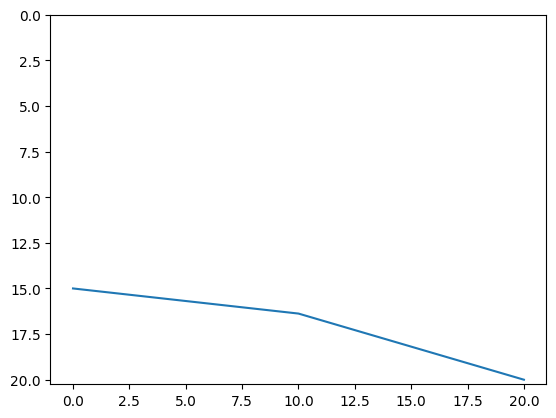

In [10]:
plt.plot(X, Post_Z)
plt.ylim([0, None])
plt.gca().invert_yaxis()

Relooking into Metropolis hastings algorithm

In [11]:
# Start with the prior information as:
theta_x = 10
X = np.linspace(0, 20, 151)

assert np.diff(X)[0] <= 0.25*theta_x, "The grid is too coarse"

## Auto correlation function: Exponential
rho = np.exp(-2*np.abs(X - X[:, None]) / theta_x)

## Start with random variable 
mu = 75
std = 50

L = np.linalg.cholesky(rho)
G = L @ np.random.normal(0, 1, (rho.shape[0], 100))

### Log normal transformation
psi_prior = np.sqrt(np.log(1 + std**2 / mu**2))
lamb_prior = np.log(mu) - 0.5 * psi_prior**2
print(psi_prior, lamb_prior)

Z_prior = np.exp(lamb_prior + psi_prior * G)

# Prior distribution
log_data = np.log(Z_prior)
prior_mean = np.mean(log_data, axis=1)
prior_cov = np.cov(log_data)

prior_f_Z = scipy.stats.multivariate_normal(prior_mean, prior_cov, allow_singular=True)

0.6064031498312961 4.133625723473651


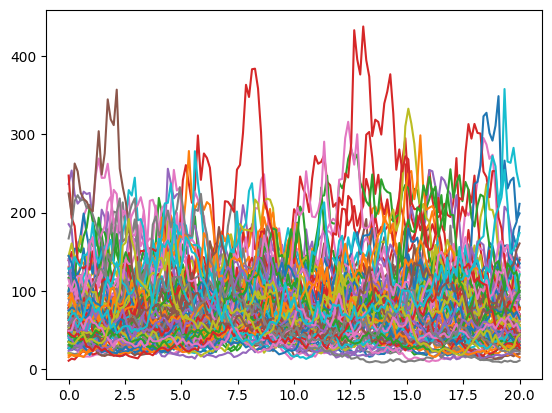

In [12]:
plt.plot(X, Z_prior[:])
plt.show()

In [13]:
## Step 2: Develop the likelihood function
def q_distribution(Z_t_1, constant_cov):
    # Log transformation
    log_data = np.log(Z_t_1)

    # Mean and covariance
    q_distr = scipy.stats.multivariate_normal(log_data, constant_cov * 0.75, allow_singular=True)

    return np.exp(q_distr.rvs())


def likelihood(Z_t, k_index, z_known):
    # Extract the values of the known values
    Z_k = Z_t[k_index]

    # Difference between the known values and the values of the known values
    diff = z_known - Z_k.ravel()

    # Likelihood function
    error_dist = scipy.stats.norm(0, 0.05)

    return np.prod(error_dist.pdf(diff))

def proposed_distribution(Z, prior_f_Z, k_index, z_known):
    # Prior distribution
    prior = prior_f_Z.pdf(np.log(Z))

    # Likelihood function
    likelihood_f = likelihood(Z, k_index, z_known)

    # Proposal distribution
    proposal = prior * likelihood_f

    return proposal

In [14]:
## Step 3: Develop the MCMC algorithm

def MCMC_algorithm(k_index, z_known, prior_cov, prior_f_Z, N=1000):
    # Initialize
    Z_t = np.exp(prior_f_Z.rvs())
    Z = np.zeros((Z_t.shape[0], N))

    # Start loop
    for i in range(N):
        # Generate the proposal distribution
        Z_t_1 = q_distribution(Z_t, prior_cov)

        # Calculate the acceptance ratio
        alpha = proposed_distribution(Z_t_1, prior_f_Z, k_index, z_known) / proposed_distribution(Z_t, prior_f_Z, k_index, z_known)

        # Acceptance probability
        u = np.random.uniform(0, 1)
        if u < alpha:
            Z_t = Z_t_1

        Z[:, i] = Z_t.ravel()

    return Z

In [15]:
# Known values
k_index = np.array([0, -1, -10, -100])
z_known = np.array([110, 50, 5, 20])

Z = MCMC_algorithm(k_index, z_known, prior_cov, prior_f_Z, N=1000)

C:\Users\kurt-\AppData\Local\Temp\ipykernel_19444\3346224195.py:14: RuntimeWarning: invalid value encountered in scalar divide
  alpha = proposed_distribution(Z_t_1, prior_f_Z, k_index, z_known) / proposed_distribution(Z_t, prior_f_Z, k_index, z_known)


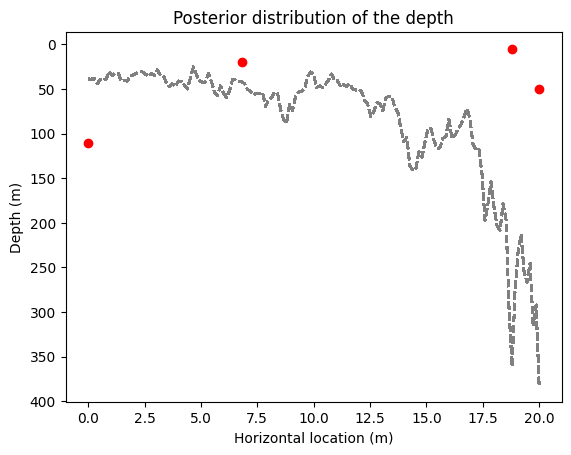

In [16]:
plt.plot(X, Z[:], '--', alpha=0.5, color='gray')
plt.plot(X[k_index], z_known, 'ro')
plt.gca().invert_yaxis()
plt.xlabel('Horizontal location (m)')
plt.ylabel('Depth (m)')
plt.title('Posterior distribution of the depth')
plt.show()

In [17]:
# Case 2: Only one known value
k_index = np.array([25])
z_known = np.array([45])

Z = MCMC_algorithm(k_index, z_known, prior_cov, prior_f_Z, N=1000)

C:\Users\kurt-\AppData\Local\Temp\ipykernel_19444\3346224195.py:14: RuntimeWarning: invalid value encountered in scalar divide
  alpha = proposed_distribution(Z_t_1, prior_f_Z, k_index, z_known) / proposed_distribution(Z_t, prior_f_Z, k_index, z_known)
C:\Users\kurt-\AppData\Local\Temp\ipykernel_19444\3346224195.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = proposed_distribution(Z_t_1, prior_f_Z, k_index, z_known) / proposed_distribution(Z_t, prior_f_Z, k_index, z_known)


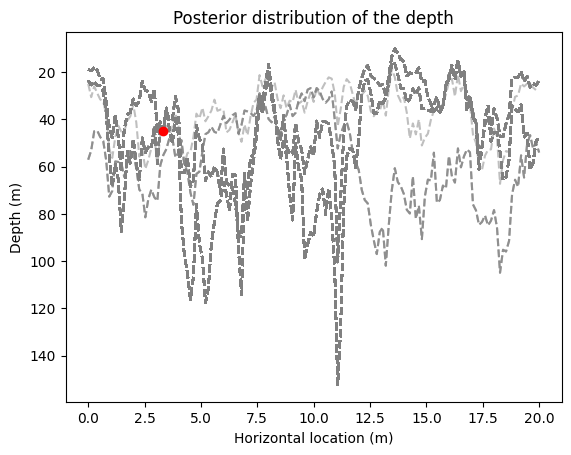

In [18]:
plt.plot(X, Z[:], '--', alpha=0.5, color='gray')
plt.plot(X[k_index], z_known, 'ro')
plt.gca().invert_yaxis()
plt.xlabel('Horizontal location (m)')
plt.ylabel('Depth (m)')
plt.title('Posterior distribution of the depth')
plt.show()

In [31]:
# Let's do an example!


# Start with the following:
Vs = [400, 1500, 1500]
h = [0,45, 150]

Text(0.5, 1.0, 'Vs profile')

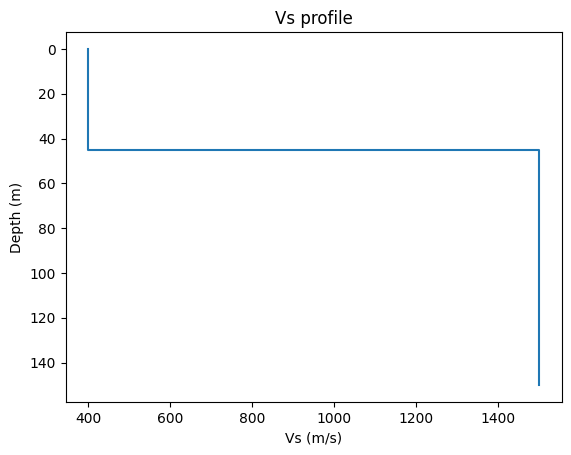

In [32]:
# Plot the Vs profile
plt.step(Vs, h)
plt.gca().invert_yaxis()
plt.xlabel('Vs (m/s)')
plt.ylabel('Depth (m)')
plt.title('Vs profile')



In [51]:
X = np.linspace(0, 10, 101)
theta_x = 50
a_hV = 10

## Auto correlation function: Exponential - 1D
rho = np.exp(-2*np.abs(X - X[:, None]) / theta_x)

## Start with random variable
mu = 145/2
std = np.sqrt(145**2/12)

L = np.linalg.cholesky(rho)
G = L @ np.random.normal(0, 1, (rho.shape[0], 1000))

### Log normal transformation
psi_prior = np.sqrt(np.log(1 + std**2 / mu**2))
lamb_prior = np.log(mu) - 0.5 * psi_prior**2

Z_prior = np.exp(lamb_prior + psi_prior * G)

# Prior distribution
log_data = np.log(Z_prior)
prior_mean = np.mean(log_data, axis=1)
prior_cov = np.cov(log_data)

prior_f_Z = scipy.stats.multivariate_normal(prior_mean, prior_cov, allow_singular=True)

In [52]:
# Known values
k_index = np.array([len(X)//2])
z_known = np.array([45])

Z = MCMC_algorithm(k_index, z_known, prior_cov, prior_f_Z, N=1000)

C:\Users\kurt-\AppData\Local\Temp\ipykernel_19444\3346224195.py:14: RuntimeWarning: invalid value encountered in scalar divide
  alpha = proposed_distribution(Z_t_1, prior_f_Z, k_index, z_known) / proposed_distribution(Z_t, prior_f_Z, k_index, z_known)
C:\Users\kurt-\AppData\Local\Temp\ipykernel_19444\3346224195.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = proposed_distribution(Z_t_1, prior_f_Z, k_index, z_known) / proposed_distribution(Z_t, prior_f_Z, k_index, z_known)


In [53]:
h

[0, 45, 150]

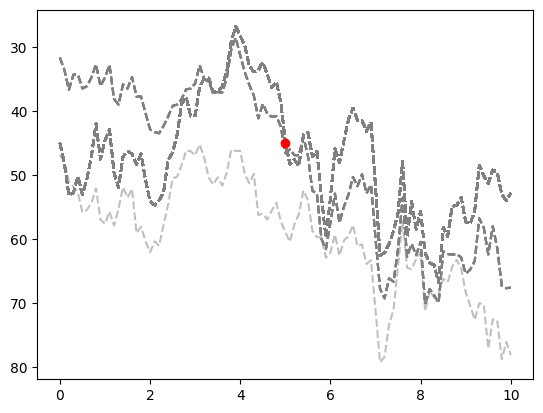

In [54]:
plt.plot(X, Z[:], '--', alpha=0.5, color='gray')
plt.plot(X[k_index], z_known, 'ro')
plt.gca().invert_yaxis()

In [55]:
# Using this information, let's approximate to closer integer 
Z_approx = np.round(Z[:,-1],0)

# Start now with unconditional Vs random field
y_val = []

for i in range(len(X)):
    y_val.append(np.arange(0, Z_approx[i]+1, 1))

# Meshgrid
X_mesh, Y_mesh = [], []
for i, x in enumerate(X):
    for y in y_val[i]:
        X_mesh.append(x)
        Y_mesh.append(y)

X_mesh = np.array(X_mesh)
Y_mesh = np.array(Y_mesh)

# Calculate exponential autocorrelation
rho = np.zeros((len(X_mesh), len(X_mesh)))
for i in range(len(X_mesh)):
    for j in range(len(X_mesh)):
        tau_x = np.abs(X_mesh[i] - X_mesh[j])
        tau_y = np.abs(Y_mesh[i] - Y_mesh[j])
        rho[i, j] = np.exp(-2*(tau_x/theta_x + tau_y/(theta_x/a_hV)))

In [56]:
# Cholesky decomposition
L = np.linalg.cholesky(rho)

# Generate random field
G = L @ np.random.normal(0, 1, (rho.shape[0], 1))

# Non gaussian random field - Log Normal 
mu = Vs[0]
std = 150

psi = np.sqrt(np.log(1 + std**2 / mu**2))
lamb = np.log(mu) - 0.5 * psi**2

Z_mesh = np.exp(lamb + psi * G)

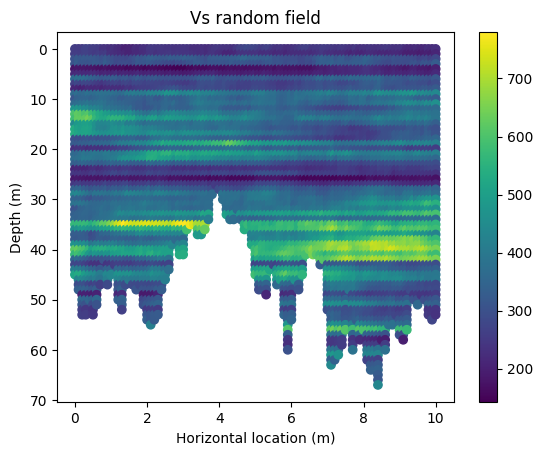

In [57]:
# Plot
plt.figure()
plt.scatter(X_mesh, Y_mesh, c=Z_mesh.ravel(), cmap='viridis')
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('Horizontal location (m)')
plt.ylabel('Depth (m)')
plt.title('Vs random field')
plt.show()

In [58]:
# Extract randomly 3 columns
ix = np.random.choice(len(X), 3, replace=False)

## Extract the positions of the meshgrid
X_examples = X[ix]

X_mesh_examples = X_mesh[np.isin(X_mesh, X_examples)]
Y_mesh_examples = Y_mesh[np.isin(X_mesh, X_examples)]
Z_mesh_examples = Z_mesh[np.isin(X_mesh, X_examples)]

# Get index where X_mesh_examples changes
ix_diff = np.where(np.diff(X_mesh_examples) != 0)[0]
# Add zero at the beginning of ix_diff
ix_diff = np.append(ix_diff, len(X_mesh_examples))
ix_diff = ix_diff + 1
ix_diff = np.insert(ix_diff, 0, 0)

# Store values
Vs_examples = []
Y_val_examples = []
for i in range(len(ix_diff)-1):
    #print(X_mesh_examples[ix_diff[i]:ix_diff[i+1]])
    Vs_examples.append(Z_mesh_examples[ix_diff[i]:ix_diff[i+1]])
    Y_val_examples.append(Y_mesh_examples[ix_diff[i]:ix_diff[i+1]])
    

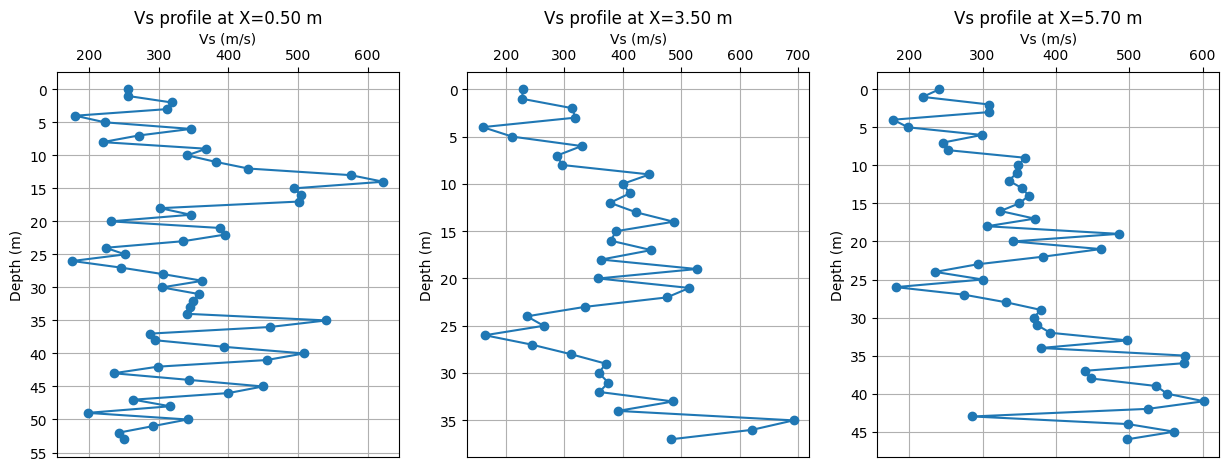

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].plot(Vs_examples[i], Y_val_examples[i], 'o-')
    ax[i].set_xlabel('Vs (m/s)')
    ax[i].set_ylabel('Depth (m)')
    ax[i].set_title(f'Vs profile at X={X_examples[i]:.2f} m')
    ax[i].invert_yaxis()
    # Set Vs labels and ticks to the top
    ax[i].xaxis.set_label_position('top')
    ax[i].xaxis.tick_top()
    # Set grid by 1 spacing in the y-axis
    ax[i].grid(True)
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(5))